In [151]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import GridSearchCV,learning_curve,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,classification_report,f1_score
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

In [152]:
x_train = pd.read_csv('data_source/X_train.csv')
y_train = pd.read_csv('data_source/y_train.csv')

x_test = pd.read_csv('data_source/X_test.csv')
y_test = pd.read_csv('data_source/y_test.csv')

x_train = x_train.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_train = y_train.loc[:,'Action']
x_test = x_test.loc[:,['Destination Port', 'NAT Source Port','Packets', 'Elapsed Time (sec)','Bytes Received','NAT Destination Port']]
y_test = y_test.loc[:,'Action']

In [153]:
X_test.columns

Index(['Source Port', 'Destination Port', 'NAT Source Port',
       'NAT Destination Port', 'Bytes', 'Bytes Sent', 'Bytes Received',
       'Packets', 'Elapsed Time (sec)', 'pkts_sent', 'pkts_received'],
      dtype='object')

In [154]:
pipe = Pipeline(steps=[
    ('scaler', RobustScaler()),
    ('classifier', RandomForestClassifier(random_state=10)) # object='multi:softmax',num_class=4,seed=42,eval_metric='merror'
])

hyperparameters = {
    'classifier__n_estimators': [5,6,7,8],  # Number of trees in the forest
    'classifier__max_depth': [3,4,5],  # Maximum depth of the trees
    'classifier__min_samples_split': [2, 5, 10],  # Minimum number of samples required to split a node
    'classifier__min_samples_leaf': [1, 2, 4]  # Minimum number of samples required at the leaf nodes
}

In [155]:
grid = GridSearchCV(pipe,hyperparameters,cv=5,scoring='f1_macro',n_jobs=-1)
grid.fit(x_train, y_train)
print("Best parameter (CV score=%0.3f):" % grid.best_score_)
print(grid.best_params_)
print(grid.best_estimator_)

Best parameter (CV score=0.876):
{'classifier__max_depth': 4, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 8}
Pipeline(steps=[('scaler', RobustScaler()),
                ('classifier',
                 RandomForestClassifier(max_depth=4, n_estimators=8,
                                        random_state=10))])


In [156]:
# Redefine the pipeline using result from gridsearch
pipe.set_params(classifier__max_depth =4,classifier__min_samples_leaf=1,
                classifier__min_samples_split=2,classifier__n_estimators=8)

pipe.fit(x_train, y_train,)

print('Training set score: ' + str(pipe.score(x_train,y_train)))
print('Test set score: ' + str(pipe.score(x_test,y_test)))

Training set score: 0.8795850028066508
Test set score: 0.966531027466938


In [157]:
train_sizes, train_scores, test_scores = learning_curve(pipe, x_train, y_train, cv=5, scoring='f1_macro')

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

/var/folders/v5/n7zzf9t13vn15ppbmryx4bdr0000gn/T/ipykernel_86739/4102985668.py:5: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=True, which='major', color='b', linestyle='-')


Text(0.5, 1.0, 'Random Forest Learning Curve')

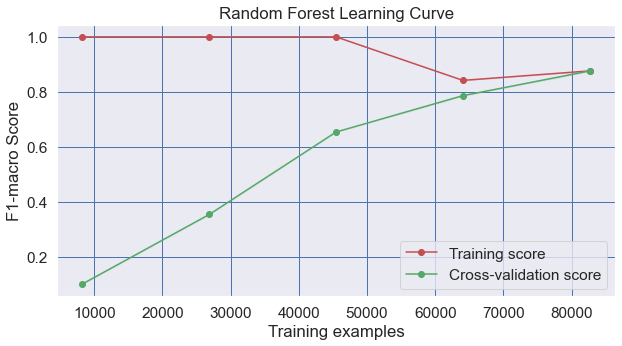

In [158]:
fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(10, 5))
plt.xlabel("Training examples")
plt.ylabel("F1-macro Score")

plt.grid(b=True, which='major', color='b', linestyle='-')

plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1,
                    color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
plt.plot(train_sizes, train_scores_mean, 'o-', color="r",
            label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g",
            label="Cross-validation score")

plt.legend(loc="best")
plt.title('Random Forest Learning Curve')

In [160]:
pipe.fit(x_train, y_train)

train_yhat = pipe.predict(x_train)
train_pipe = f1_score(train_yhat,y_train,average='macro')

test_yhat = pipe.predict(x_test)
test_pipe = f1_score(test_yhat,y_test,average='macro')
print('Train Score\n',classification_report(y_train,train_yhat))
print('Test Score\n',classification_report(y_test, test_yhat))
print(f"AVG F1-Score Train: {train_pipe}\nAVG F1-Score Test: {test_pipe}")

Train Score
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     26036
           1       0.71      0.87      0.78     25387
           2       0.96      1.00      0.98     26234
           3       0.89      0.64      0.74     25669

    accuracy                           0.88    103326
   macro avg       0.89      0.88      0.88    103326
weighted avg       0.89      0.88      0.88    103326

Test Score
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     11292
           1       1.00      0.86      0.92      4496
           2       0.94      1.00      0.97      3856
           3       0.03      0.62      0.05        16

    accuracy                           0.97     19660
   macro avg       0.74      0.87      0.73     19660
weighted avg       0.99      0.97      0.97     19660

AVG F1-Score Train: 0.8759615972783359
AVG F1-Score Test: 0.734486662254044


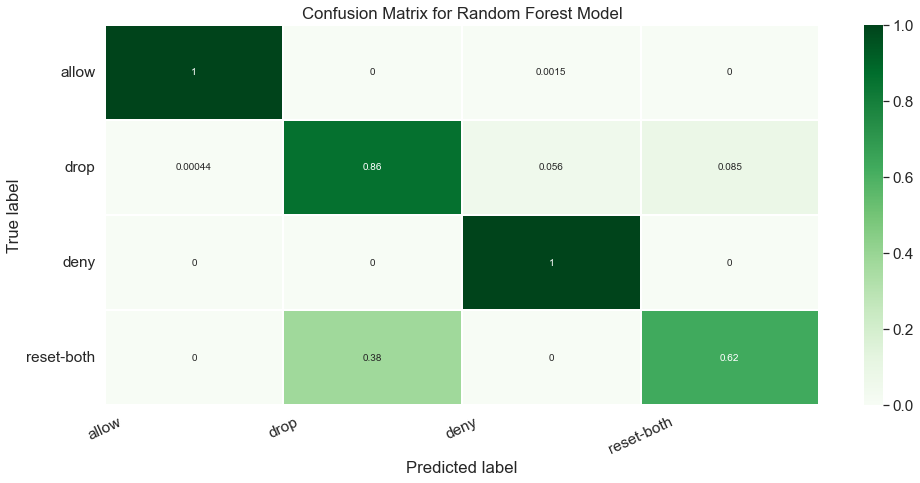

In [149]:
# Get and reshape confusion matrix data
matrix = confusion_matrix(y_test, test_yhat)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

# Build the plot
plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap=plt.cm.Greens, linewidths=0.2)

# Add labels to the plot
class_names = ['allow','drop','deny','reset-both']
tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks, class_names, rotation=25)
plt.yticks(tick_marks2, class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

# About 75% of the time, reset-both were mislabeled as drop!

In [164]:
rf_val_score = cross_val_score(pipe,x_train,y_train,scoring='f1_macro',cv=5)
print(f"Average lr cv score: {round(np.mean(rf_val_score),4)}\nlr SD: {round(rf_val_score.std(),4)}")

Average lr cv score: 0.8759
lr SD: 0.0018
